In [15]:
url_cheptel = "https://www.insee.fr/fr/statistiques/fichier/2012795/TCRD_073.xlsx"

import pandas as pd
cheptel2022 = pd.read_excel(url_cheptel, header = 3, na_values="nd")
type_cheptel = cheptel2022.columns[~cheptel2022.columns.str.startswith("Unnamed")]
cheptel2022.loc[:, type_cheptel] = cheptel2022.loc[:,type_cheptel].mul(1000)
cheptel2022 = cheptel2022.rename(
    {"Unnamed: 0": "code", "Unnamed: 1": "departement", "Volailles gallus": "Volailles"},
    axis = "columns") 
cheptel2022.head(3)

,code,departement,Bovins,Porcins,Ovins,Caprins,Volailles
0,01,Ain,159900.0,134100.0,21900.0,7200.0,NaN
1,02,Aisne,180400.0,48700.0,29100.0,800.0,NaN
2,03,Allier,495900.0,88000.0,147100.0,9100.0,NaN


In [2]:
import requests
import zipfile
import os

# URL of the zip file
url_population = "https://www.insee.fr/fr/statistiques/fichier/7739582/ensemble.zip"

# Local path to save the downloaded zip file
zip_path = "ensemble.zip"

# Download the file
response = requests.get(url_population)
with open(zip_path, "wb") as file:
    file.write(response.content)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("unzipped_files")

# Clean up the downloaded zip file (optional)
os.remove(zip_path)

print("Download and extraction complete!")


population2021 = pd.read_csv("./unzipped_files/donnees_departements.csv", sep = ";")
population2021.head(3)

Download and extraction complete!


,REG,Région,DEP,Département,NBARR,NBCAN,NBCOM,PMUN,PTOT
0,84,Auvergne-Rhône-Alpes,01,Ain,4,23.0,392,663202,678981
1,32,Hauts-de-France,02,Aisne,5,21.0,798,527468,539099
2,84,Auvergne-Rhône-Alpes,03,Allier,3,19.0,317,334872,343485


In [3]:
data_departement = cheptel2022.merge(
    population2021, right_on = "DEP", left_on = "code"
).drop(["departement", "DEP"], axis = "columns")

In [4]:
from cartiflette import carti_download
dep = carti_download(
    values=["France"],
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="FRANCE_ENTIERE_DROM_RAPPROCHES",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


In [5]:
data_departement = dep.merge(data_departement, left_on = "INSEE_DEP", right_on = "code")

In [6]:
data_departement.head(3)

,INSEE_DEP,PAYS,LIBELLE_DEPARTEMENT,POPULATION,SOURCE,geometry,code,Bovins,Porcins,Ovins,Caprins,Volailles gallus,REG,Région,Département,NBARR,NBCAN,NBCOM,PMUN,PTOT
0,43,France,Haute-Loire,227570,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"POLYGON ((3.89745 45.35699, 3.89731 45.35658, ...",43,209400.0,61000.0,146500.0,14800.0,NaN,84,Auvergne-Rhône-Alpes,Haute-Loire,3,19.0,257,227284,233980
1,65,France,Hautes-Pyrénées,229567,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((-0.09705 43.58220, -0.09642 43...",65,99200.0,44400.0,128800.0,5300.0,NaN,76,Occitanie,Hautes-Pyrénées,3,17.0,469,230956,236859
2,29,France,Finistère,915090,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((-3.97907 47.70396, -3.97925 47...",29,395900.0,2347500.0,16000.0,3300.0,NaN,53,Bretagne,Finistère,4,27.0,277,921638,946331


In [7]:
data_departement["ratio_" + type_cheptel] = (
    data_departement.loc[:,type_cheptel].div(data_departement['PTOT'], axis = 0)
)
data_departement["ratio_" + type_cheptel] = data_departement["ratio_" + type_cheptel] > 1

In [8]:
data_departement.head(2)

,INSEE_DEP,PAYS,LIBELLE_DEPARTEMENT,POPULATION,SOURCE,geometry,code,Bovins,Porcins,Ovins,...,NBARR,NBCAN,NBCOM,PMUN,PTOT,ratio_Bovins,ratio_Porcins,ratio_Ovins,ratio_Caprins,ratio_Volailles gallus
0,43,France,Haute-Loire,227570,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"POLYGON ((3.89745 45.35699, 3.89731 45.35658, ...",43,209400.0,61000.0,146500.0,...,3,19.0,257,227284,233980,False,False,False,False,False
1,65,France,Hautes-Pyrénées,229567,IGN:EXPRESS-COG-CARTO-TERRITOIRE,"MULTIPOLYGON (((-0.09705 43.58220, -0.09642 43...",65,99200.0,44400.0,128800.0,...,3,17.0,469,230956,236859,False,False,False,False,False


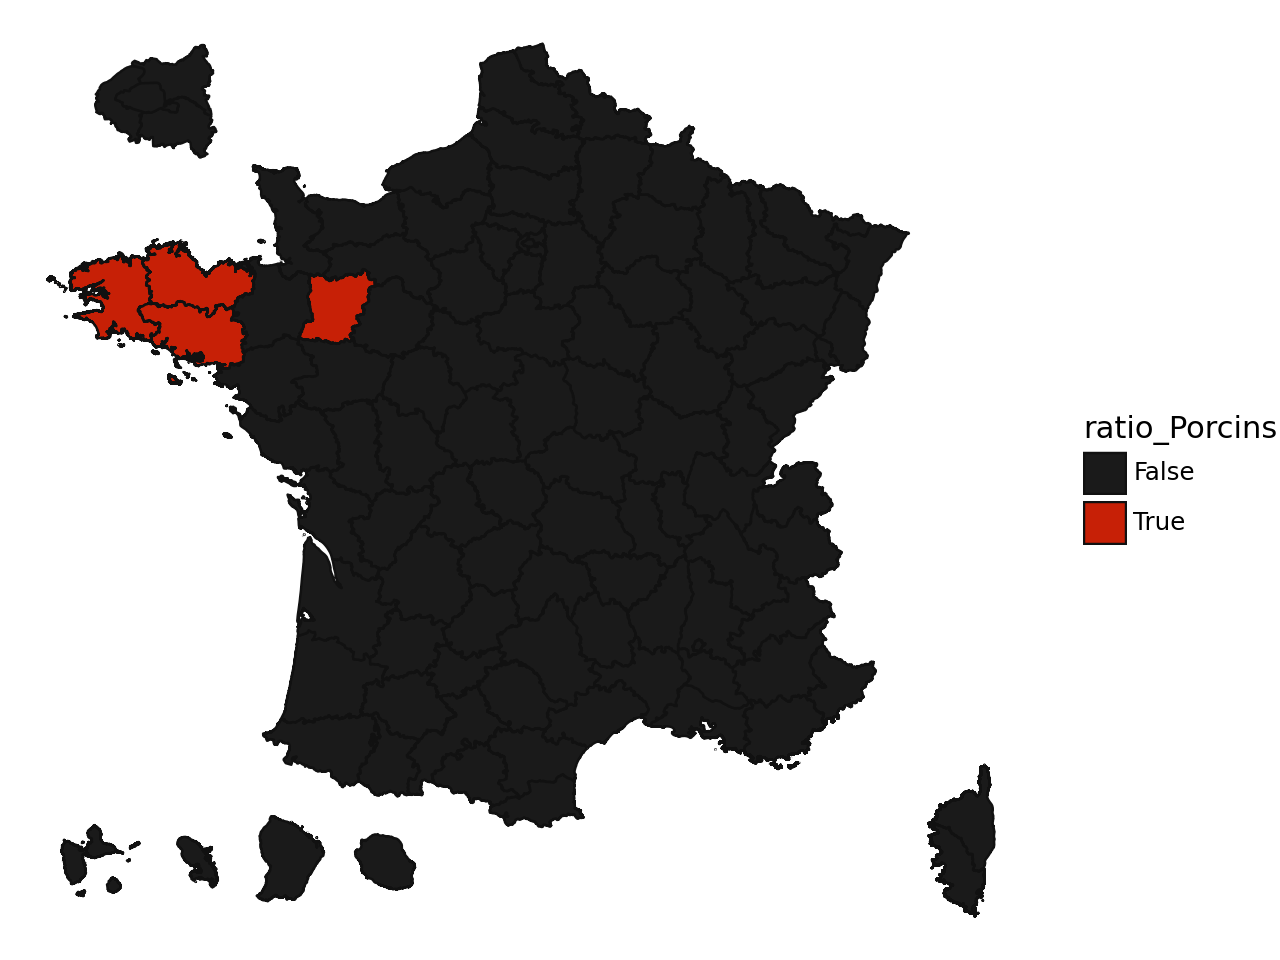

In [33]:
from plotnine import *
(
    ggplot(data_departement) +
    geom_map(aes(fill = "ratio_" + type_cheptel[1])) +
    scale_fill_manual(values = {True: "#c72006", False: "#1a1a1a"}) +
    theme_void()
)